# 对比传统聚类算法

在同一个数据集上，对比 DEC 与 K-Means, DBSCAN 两种传统聚类算法的效果。

In [1]:
import os
import numpy as np

import utils

from typing import Optional
from sklearn.cluster import KMeans, DBSCAN
from scipy.optimize import linear_sum_assignment

CSV_PATH = './data'

os.environ["LOKY_MAX_CPU_COUNT"] = "4"

## 1. 加载数据

In [2]:
# 将 csv 读入 DataFrame
train_csv_path = os.path.join(CSV_PATH, 'train_embed_label.csv')
train_df = utils.read_embedding_csv(csv_path=train_csv_path,
                                    ebd_cols=['embeddings'])
train_embeds = np.array(train_df['embeddings'].tolist())
train_labels = train_df['labels'].values

len(train_df), len(set(train_df['labels'].tolist()))

(10000, 100)

In [3]:
train_df.head()

,embeddings,labels
0,"[0.013868028298020363, -0.01785886101424694, 0...",19
1,"[0.03667556121945381, -0.08648686856031418, 0....",29
2,"[0.0741165354847908, -0.008068534545600414, 0....",0
3,"[-0.034709382802248, 0.048253390938043594, -0....",11
4,"[-0.06292618066072464, 0.06838615983724594, 0....",1


## 2. 评估函数

使用 [vlukiyanov/pt-dec](https://github.com/vlukiyanov/pt-dec/blob/master/ptdec/utils.py) 库提供的函数 `cluster_accuracy` 计算准确率 (Accuracy):

In [4]:
def cluster_accuracy(y_true, y_predicted, cluster_number: Optional[int] = None):
    """
    Calculate clustering accuracy after using the linear_sum_assignment function in SciPy to
    determine reassignments.

    :param y_true: list of true cluster numbers, an integer array 0-indexed
    :param y_predicted: list  of predicted cluster numbers, an integer array 0-indexed
    :param cluster_number: number of clusters, if None then calculated from input
    :return: reassignment dictionary, clustering accuracy
    """
    if cluster_number is None:
        cluster_number = (
            max(y_predicted.max(), y_true.max()) + 1
        )  # assume labels are 0-indexed
    count_matrix = np.zeros((cluster_number, cluster_number), dtype=np.int64)
    for i in range(y_predicted.size):
        count_matrix[y_predicted[i], y_true[i]] += 1

    row_ind, col_ind = linear_sum_assignment(count_matrix.max() - count_matrix)
    reassignment = dict(zip(row_ind, col_ind))
    accuracy = count_matrix[row_ind, col_ind].sum() / y_predicted.size
    return reassignment, accuracy

## 3. K-means 算法

K-Means 是一种经典的无监督聚类算法，通过迭代优化将数据点划分为 K 个簇，每个簇由质心（Centroid）代表。

1）目标函数

最小化所有数据点到其簇质心的距离平方和。

$J = \sum_{i=1}^{k} \sum_{x_j \in C_i} \|x_j - \mu_i\|^2$

其中：

- $k$ 是预设的簇数
- $C_{i}$ 表示第 $i$ 个簇 
- $x_{j}$ 是数据点
- $\mu_{i}$ 是第 $i$ 个簇的中心

2）算法步骤

1. **初始化**：随机选择 K 个质心（或使用优化方法如 k-means++）
2. **分配簇**：将每个数据点分配到最近的质心
3. **更新质心**：计算每个簇中所有点的平均值，更新质心位置
4. **重复**：直到质心不再变化或达到最大迭代次数

In [5]:
# 训练
kmeans = KMeans(n_clusters=100, init='k-means++', random_state=42)
kmeans.fit(train_embeds)

KMeans(n_clusters=100, random_state=42)

In [6]:
# 获取聚类标签
y_pred = kmeans.labels_
y_pred

array([56, 57, 29, ..., 55, 47, 26])

In [7]:
# 评估
reassignment, accuracy = cluster_accuracy(y_true=train_labels,
                                          y_predicted=y_pred,
                                          cluster_number=100)
print(f'accuracy: {accuracy:.4f}')

accuracy: 0.7025


## 4. DBSCAN 算法

DBSCAN 是一种基于密度的算法，能发现任意形状的簇。其核心思想是连接高密度区域，将低密度区域视为噪声直接丢弃。与 K-Means 不同，DBSCAN 无须事先指定聚类个数。

1）核心参数

- **eps**：指定一个点的邻域范围。也就是，某个点的邻域内的其他点如果距离不超过 ε，那么这些点就属于该点的邻居。
- **min_samples**：定义一个簇的最小点数。当一个点的邻域内包含至少 min_samples 个点时，这个点被认为是一个核心点（Core Point）。核心点是簇的中心，可以扩展成一个簇。

2）DBSCAN 对三种点的定义

- **核心点（Core Point）**：如果一个点的邻域内包含至少 MinPts 个点，那么这个点是一个核心点，并且它可以扩展成一个簇。
- **边界点（Border Point）**：如果一个点不是核心点，但是它在某个核心点的邻域范围内，那么它被认为是边界点。
- **噪声点（Noise Point）**：如果一个点既不是核心点也不是边界点，那么它被认为是噪声点，通常被忽略或标记为异常值。

通过核心点与核心点之间的连接，DBSCAN 中的聚类可以自动生长成簇。这种方式的好处是可以通过密度自动确定簇的数量，且对噪声数据不敏感。

更多关于 DBSCAN 的细节可以参考：[luochang212/stream-clustering](https://github.com/luochang212/stream-clustering/blob/main/1.DBSCAN.ipynb)

有效点个数：4917
聚类个数：179
前100个最大类别的样本数量：4660


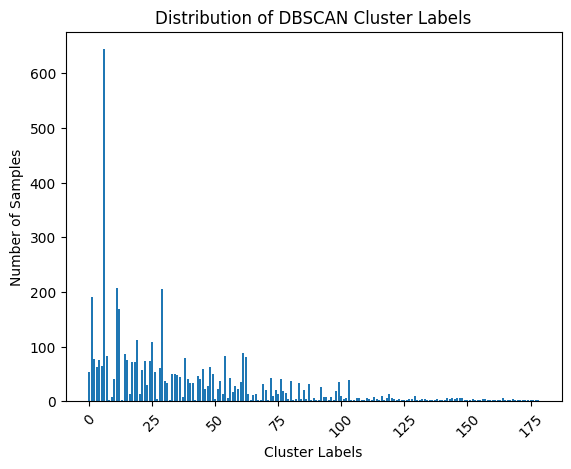

In [38]:
# 设置参数
eps = 0.36
min_samples = 3

# 创建 DBSCAN 模型，对于向量使用 cosine 作为度量
dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')

# 进行聚类
labels = dbscan.fit_predict(train_embeds)

print(f'有效点个数：{sum([1 for e in labels if e != -1])}')
print(f'聚类个数：{len(set([e for e in labels if e != -1]))}')
print(f'前100个最大类别的样本数量：{utils.sum_top_100_categories(labels=labels)}')

utils.plot_labels_distribution(labels=labels)

DBSCAN 是对 `eps` 和 `min_samples` 两个参数很敏感的算法。我们按照以下三个原则来微调它：

1. **有效点个数**：由于 DBSCAN 会将边缘点的标签设为 -1，等同于丢弃，因此我们希望有效点个数尽可能多
2. **聚类个数**：由于我们知道实际的聚类个数是 100，所以我们希望最终的类别数能接近 100
3. **标签**：我们不希望大量样本堆积在少量标签上（和实际情况不符），我们希望样本尽可能均匀

In [39]:
# 1. 直接评估
reassignment, accuracy = cluster_accuracy(y_true=train_labels,
                                          y_predicted=labels,
                                          cluster_number=None)
print(f'accuracy: {accuracy:.4f}')

accuracy: 0.3430


In [40]:
# 2. 剔除 -1 后，取样本量前 100 的类别进行评估
final_y_pred, final_y_true, encoded_y_pred, mapping = utils.process_predictions(y_pred=labels,
                                                                                y_true=train_labels)
reassignment, accuracy = cluster_accuracy(y_true=final_y_true,
                                          y_predicted=encoded_y_pred,
                                          cluster_number=100)
print(f'accuracy: {accuracy:.4f}')
print(f'sample_num / total_num: {len(final_y_pred)} / {len(train_labels)}')

accuracy: 0.7084
sample_num / total_num: 4660 / 10000


## 5. 结论

DEC 模型和传统的 K-Means 模型的准确率类似，都在 0.7 左右。